In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyspark
import datetime
from pyspark.sql.functions import col, to_timestamp, expr, collect_list, struct
from pyspark.sql.window import Window
from pyspark.sql import functions as F

def plottar_grafico(x, y, xlabel = '', ylabel = '', rotation = 0, plotTimeStamp = 0, label = False, title = False):
    # Plotar o gráfico
    fig, ax = plt.subplots()
    if(not label):
        ax.plot(x, y)
    else:
        ax.plot(x, y, label=label)
        
    if(title):
        ax.set_title(f"Número Médio de Holders para a Moeda {symbol} ao longo do Tempo")

    # Formatar o eixo x para exibir a data/hora
    if plotTimeStamp:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=rotation)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

In [2]:
def filter_last_n_blocks(df, atual_block_id, n):
    min_block_id = atual_block_id - n
    filtered_df = df.filter((df["Block_ID"] >= min_block_id) & (df["Block_ID"] < atual_block_id))
    return filtered_df

def get_dataframes(num_last_blocks = 50):
    block_df = None
    file_path = "../Scripts/output/block/block.csv"
    # Ler o arquivo CSV
    block_df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    swap_df = None
    file_path = "../Scripts/output/swap/swap_transactions.csv"
    # Ler o arquivo CSV
    swap_df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    transaction_df = None
    file_path = "../Scripts/output/transaction/transactions.csv"
    # Ler o arquivo CSV
    transaction_df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    last_block = block_df.agg(F.max("Block_ID")).collect()[0][0]
    
    block_df = filter_last_n_blocks(block_df, last_block, num_last_blocks)
    transaction_df = filter_last_n_blocks(transaction_df, last_block, num_last_blocks)
    swap_df = filter_last_n_blocks(swap_df, last_block, num_last_blocks)
    
    return block_df, transaction_df, swap_df

In [3]:
def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))

def clean_swap_dataframe(swap_df):
    swap_df_cleaned = swap_df.select([to_null(c).alias(c) for c in swap_df.columns]).na.drop()

    swap_df_cleaned = swap_df_cleaned.withColumn("From_Token_Price", when(col("From_Token_Price") == 0, float('nan')).otherwise(col("From_Token_Price")))
    swap_df_cleaned = swap_df_cleaned.withColumn("To_Token_Price", when(col("To_Token_Price") == 0, float('nan')).otherwise(col("To_Token_Price")))
    
    return swap_df_cleaned

In [4]:
def combine_dataframes(block_df, transaction_df, swap_df_cleaned):
    combined_altered_df = block_df.drop("Gas_Limit")
    combined_altered_df = combined_altered_df.drop("Gas_Used")
    combined_altered_df = combined_altered_df.drop("Timestamp_Block")
    df_combined = block_df.join(transaction_df, "Block_ID").join(swap_df_cleaned, "Hash_Transaction")
    
    return df_combined

In [5]:
def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape

def get_gas(transaction_df):
    transaction_df_altered = transaction_df.withColumn('Timestamp_Transaction', to_timestamp(col('Timestamp_Transaction')))

    # Criar a coluna Gas_Utilizado, no qual Gas_Utilizado é o preço do gás vezes o limite
    transaction_df_altered = transaction_df_altered.withColumn("Transaction_Fee", expr("Gas_Price * Gas_Used"))

    # Calcular a média de 'Gás_Usado' agrupada por data e hora
    grouped_df = transaction_df_altered.groupBy('Timestamp_Transaction').mean('Transaction_Fee')

    # Ordenar os valores pela coluna 'Timestamp_Transacao'
    ordered_df = grouped_df.orderBy('Timestamp_Transaction')
    
    # Obter os valores das colunas 'Timestamp_Transacao' e 'avg(Gás_Usado)' em listas
    # timestamps = ordered_df.select('Timestamp_Transaction').rdd.flatMap(lambda x: x).collect()
    # avg_gas_used = ordered_df.select('avg(Transaction_Fee)').rdd.flatMap(lambda x: x).collect()
    
    timestamps = [val['Timestamp_Transaction'] for val in ordered_df.select('Timestamp_Transaction').collect()]
    avg_gas_used = [val['avg(Transaction_Fee)'] for val in ordered_df.select('avg(Transaction_Fee)').collect()]
        
    return timestamps, avg_gas_used

In [6]:
def get_holders_most_purchased_coins(df_combined):
    # Obtenha as 10 moedas mais compradas
    top_10_compradas = df_combined.filter(df_combined.To_Token_Symbol.isNotNull()) \
                                 .groupBy("To_Token_Symbol") \
                                 .count() \
                                 .orderBy(F.desc("count")) \
                                 .limit(10) \
                                 .select(col("To_Token_Symbol").alias("Token_Symbol"))

    # Obtenha as transações de compra de determinada moeda e o número de holders
    compras_df = df_combined.alias("compras") \
                           .join(top_10_compradas, top_10_compradas.Token_Symbol == col("compras.To_Token_Symbol"), "inner") \
                           .select("compras.Timestamp_Transaction", "compras.To_Token_Symbol", "compras.To_Token_Holders_Count") \
                           .withColumnRenamed("To_Token_Symbol", "Token_Symbol") \
                           .withColumnRenamed("To_Token_Holders_Count", "Token_Holders_Count")

    # Obtenha as transações de venda de determinada moeda e o número de holders
    vendas_df = df_combined.alias("vendas") \
                          .join(top_10_compradas, top_10_compradas.Token_Symbol == col("vendas.From_Token_Symbol"), "inner") \
                          .select("vendas.Timestamp_Transaction", "vendas.From_Token_Symbol", "vendas.From_Token_Holders_Count") \
                          .withColumnRenamed("From_Token_Symbol", "Token_Symbol") \
                          .withColumnRenamed("From_Token_Holders_Count", "Token_Holders_Count")

    result_df = compras_df.unionAll(vendas_df)
    
    # Agrupe o dataframe e calcule a mediana do número de holders para cada moeda em cada timestamp
    grouped_df = result_df.groupBy("Timestamp_Transaction", "Token_Symbol").agg(expr("percentile_approx(Token_Holders_Count, 0.5)").alias("median"))

    # Ordene o dataframe pelo campo "Timestamp_Transaction"
    sorted_df = grouped_df.orderBy("Timestamp_Transaction")

    # Coleta os dados do dataframe para uso no matplotlib
    data_dict = {}

    # Agrupe o dataframe e calcule a mediana do número de holders para cada moeda em cada timestamp
    grouped_df = sorted_df.groupBy("Token_Symbol").agg(collect_list(struct("Timestamp_Transaction", "median")).alias("data_list"))

    # Converta o resultado em um dicionário
    data_dict = {row["Token_Symbol"]: {"timestamps": [r["Timestamp_Transaction"] for r in row["data_list"]],
                                        "holders_counts": [r["median"] for r in row["data_list"]]}
                 for row in grouped_df.collect()}
    
    return data_dict

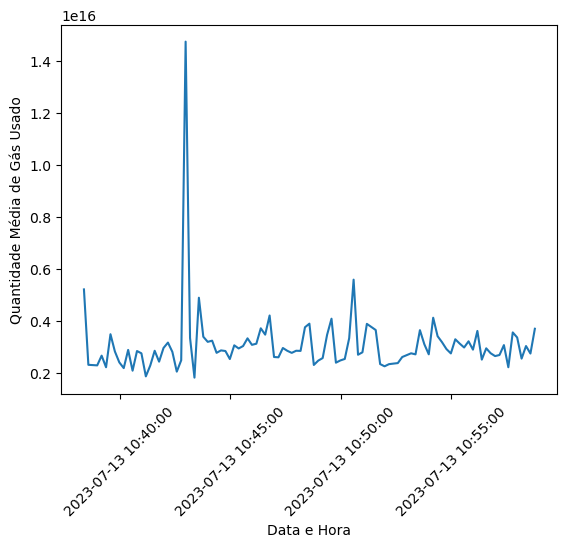

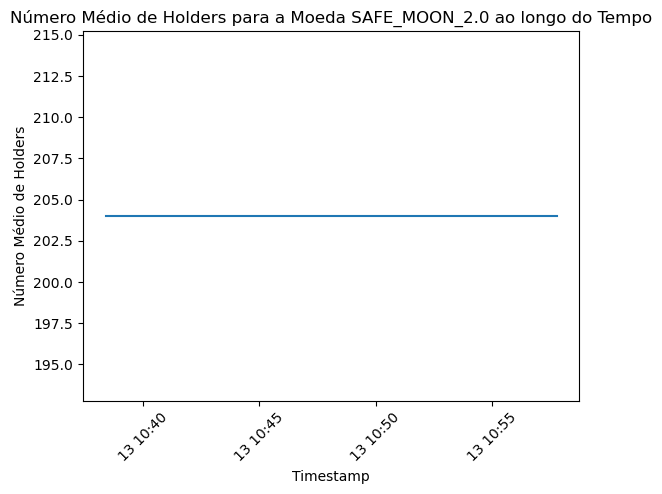

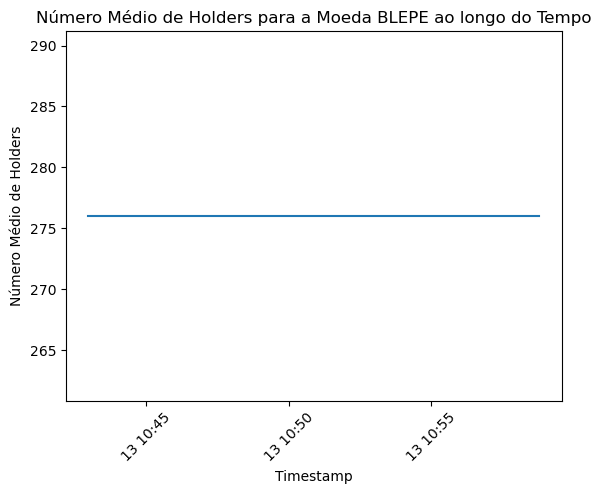

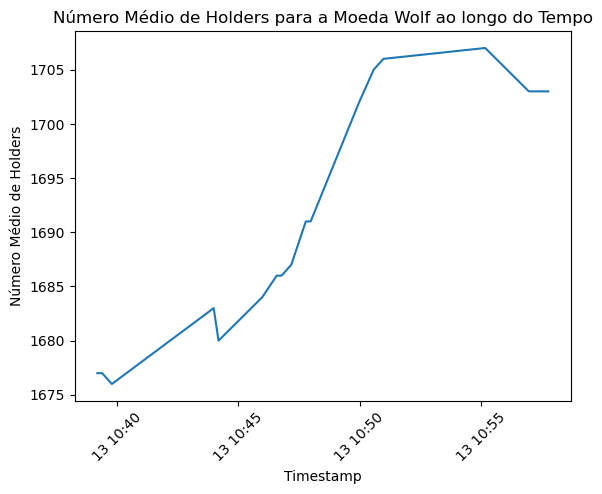

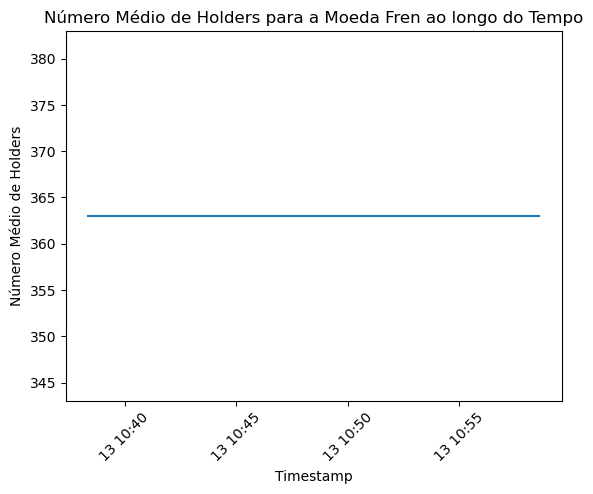

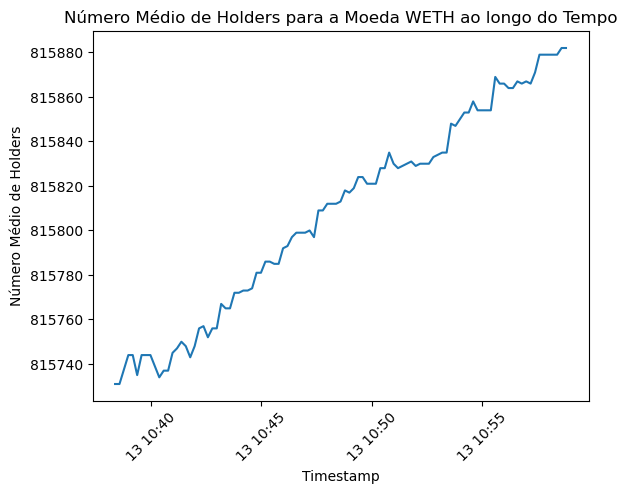

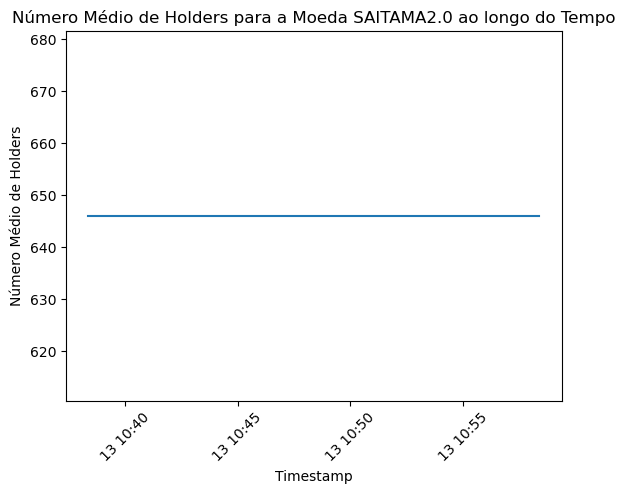

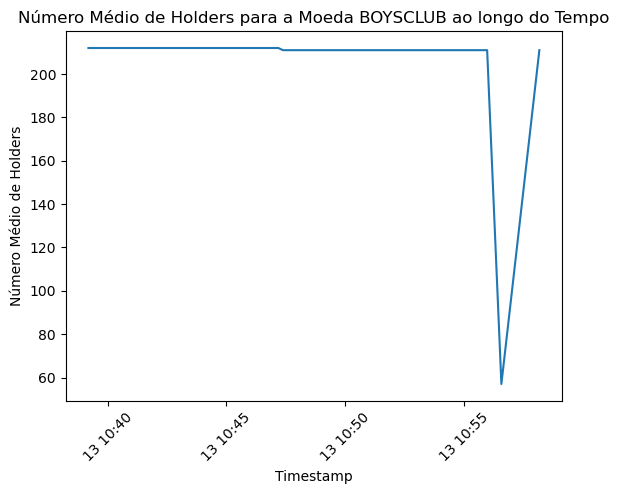

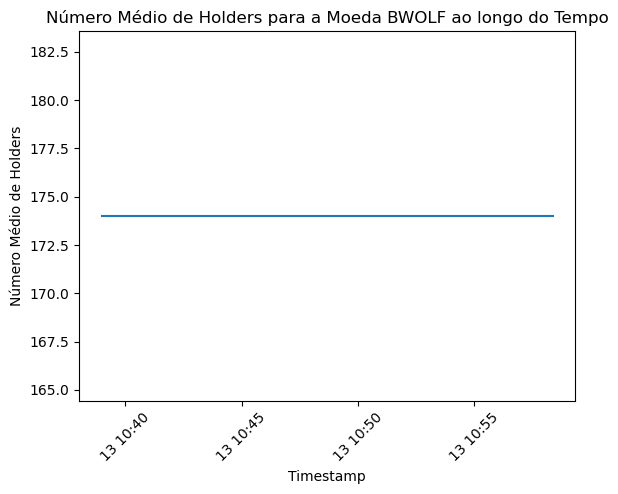

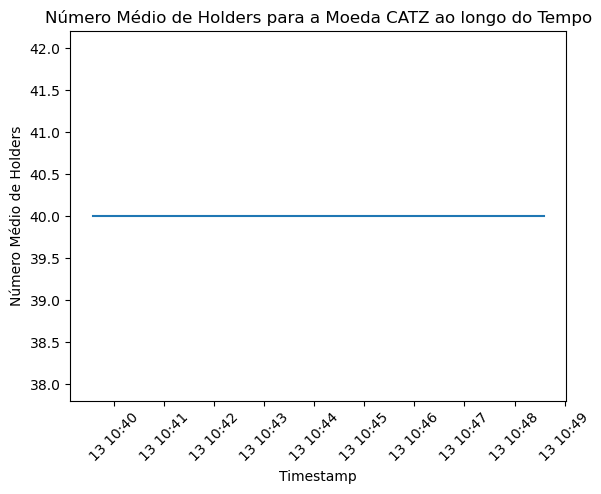

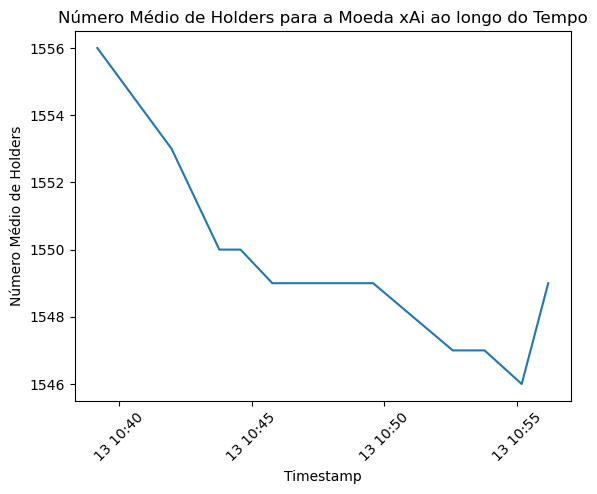

KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
from pyspark.sql.functions import col, isnan, when, trim
from pyspark.sql import functions as F

import os
import sys
from pyspark.sql import SparkSession

output_folder = "../Scripts/output"

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
num_last_blocks = 100

spark = SparkSession.builder \
    .appName("Análise de Transações Ethereum") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

while True:
    clear_output(wait=True)
    
    block_df, transaction_df, swap_df = get_dataframes(num_last_blocks)
    timestamps, avg_gas_used = get_gas(transaction_df)
    plottar_grafico(timestamps, avg_gas_used, 'Data e Hora', 'Quantidade Média de Gás Usado', 45, 1)
    
    swap_df_cleaned = clean_swap_dataframe(swap_df)
    df_combined = combine_dataframes(block_df, transaction_df, swap_df_cleaned)
    data_dict = get_holders_most_purchased_coins(df_combined)
    for symbol, data in data_dict.items():
        timestamps = data["timestamps"]
        holders_counts = data["holders_counts"]

        # Converte os timestamps em formato Unix para formato de data e hora
        dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
        
        plottar_grafico(dates, holders_counts, 'Timestamp', 'Número Médio de Holders', 45, 0, symbol, f"Número Médio de Holders para a Moeda {symbol} ao longo do Tempo")
        
    plt.pause(25)
    time.sleep(25)